In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt

RTT 1:	 11
RTT 2:	 12
RTT 3:	 13
RTT 4:	 14
RTT 5:	 4
RTT 6:	 5
RTT 7:	 6
RTT 8:	 7
RTT 9:	 8
RTT 10:	 2
RTT 11:	 3
RTT 12:	 4
RTT 13:	 5
RTT 14:	 6
RTT 15:	 1
RTT 16:	 2
RTT 17:	 3
RTT 18:	 4
RTT 19:	 5
RTT 20:	 1
RTT 21:	 2
RTT 22:	 3
RTT 23:	 4
RTT 24:	 5
RTT 25:	 1
RTT 26:	 2
RTT 27:	 3
RTT 28:	 4
RTT 29:	 5
RTT 30:	 1
RTT 31:	 2
RTT 32:	 3
RTT 33:	 4
RTT 34:	 5
RTT 35:	 1
RTT 36:	 2
RTT 37:	 3
RTT 38:	 4
RTT 39:	 5
RTT 40:	 1
RTT 41:	 2
RTT 42:	 3
RTT 43:	 4
RTT 44:	 5
RTT 45:	 1
RTT 46:	 2
RTT 47:	 3
RTT 48:	 4
RTT 49:	 5
RTT 50:	 1


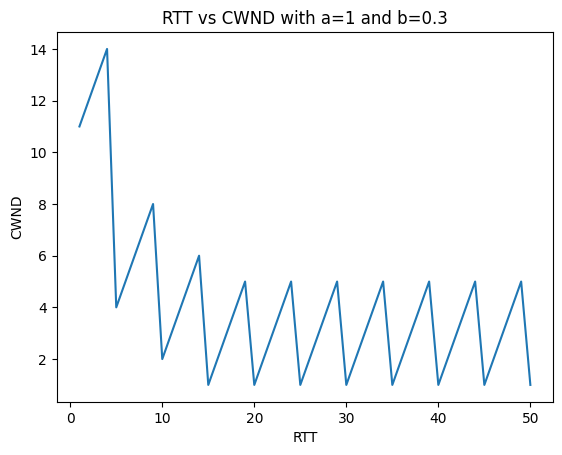

In [34]:
def AIMD(a:int=1, b:float=0.5, cwnd:int=10, data_packet:tuple=(None, "Dropped"), RTT_tracker:list=[])->list:
    """This function mimics the Additive Increase and Multiplicative Decrease Mechanism in TCP Congestion Control.
 
    Parameters
    ----------
    a: int-type
    This constant controls the rate of Additive Increase. This optimises the efficiency of the network.
    
    b: float-type
    This constant controls the rate of Multiplicative Decrease. This optimises the fairness of the network.
    This value is between 0 (exclusive) and alpha (exclusive).
    
    With these two parameters, the network system converges to optimal network conditions where the fairness line intersects with the 
    efficiency line.
    
    cwnd: int-type
    This denotes the current window size.
    
    data_packet: tuple-type
    This represents the data packet to be transferred through the network.
    
    RTT_tracker: list-type
    This tracks the RTT to cwnd size.
    
    Returns
    -------
    cwnd load
    """
    _, status = data_packet
    
    if status == 'Transfer':
        cwnd += a
    else:
        cwnd = math.floor(cwnd * b)
        
    RTT_tracker.append(cwnd)
    
    return cwnd
        
# Set Up for Data
data_packets = [(x, "Transfer") if x % 5 != 0 else (x, "Dropped") for x in range(1, 51)]

# Parameters
cwnd = 10
a = 1
b = 0.3

# Iterate
RTT_tracker = []
for data_packet in data_packets:
    cwnd = AIMD(a, b, cwnd, data_packet, RTT_tracker)

# Visualise
x, y = [], []
for idx, cwnd in enumerate(RTT_tracker):
    print(f"RTT {idx + 1}:\t", cwnd)
    x.append(idx + 1)
    y.append(cwnd)

plt.plot(x, y)
plt.xlabel("RTT")
plt.ylabel("CWND")
plt.title(f"RTT vs CWND with a={a} and b={b}")
plt.show()

In [65]:
from abc import ABC, abstractmethod
# Variations of AIMD
class TCPReno():
    '''
    Alpha and Beta are 1 and 0.5 respectively
    '''
    def __init__(self, cwnd):
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd += 1
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = self.cwnd * 0.5
        self.RTT_tracker.append(self.cwnd)


class GAIMD():
    '''
    Generaic AIMD -> Adjustable Alpha and Beta
    Linear
    '''
    def __init__(self, alpha, beta, cwnd):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd += self.alpha
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = self.cwnd * self.beta
        self.RTT_tracker.append(self.cwnd)

class NonLinearAIMD(ABC):
    '''
    Non-Linear TCP with different non-linear increment functions
    '''
    def __init__(self, alpha, beta, cwnd, ssthresh):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.ssthresh = ssthresh
        self.RTT_tracker = [cwnd]
    
    @abstractmethod
    def update_AI(self):
        pass

    @abstractmethod
    def update_MD(self):
        '''
        For better control of adjustments to variables -> Mostly Beta variable
        '''
        pass

    def AI(self):
        if self.cwnd < self.ssthresh:
            self.update_AI()
        self.cwnd += self.alpha
        

        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.update_MD()
        self.cwnd = self.cwnd * self.beta
        self.RTT_tracker.append(self.cwnd)
    
class DoubleAIMD(NonLinearAIMD):
    def non_linear_AI(self):
        self.cwnd *= 2

    def update_MD(self):
        self.alpha = 1
        pass

class ExponentialAIMD(NonLinearAIMD):
    def __init__(self, alpha, beta, cwnd, ssthresh, exponent):
        super().__init__(alpha, beta, cwnd, ssthresh)
        self.exponent = exponent
        
    def update_AI(self):
        self.alpha *= math.pow(self.cwnd, self.exponent)
    
    def update_MD(self):
        self.alpha = 1

class LogAIMD(NonLinearAIMD):        
    def update_AI(self):
        self.alpha *= math.log(self.cwnd+1)
    
    def update_MD(self):
        self.alpha = 1



In [36]:
class Network():
    def __init__(self, capacity, users):
        self.capacity = capacity
        self.users = users

    
    def run_one_RTT(self):
        c_sum = 0
        for user in self.users:
            c_sum += user.cwnd
        
        if c_sum <= self.capacity:
            # print('Additive I')
            for user in self.users:
                user.AI()
        
        else:
            # print('Multiplicative D')
            for user in self.users:
                user.MD()
    
    def visualise(self, name=None):
        '''
        Only shows the first 2 users
        '''
        plt.plot(self.users[0].RTT_tracker, self.users[1].RTT_tracker)
        
        plt.plot([0, self.capacity], [self.capacity, 0], 'k-', label='Efficiency Line')
        
        # Equal fariness
        plt.plot([0, self.capacity], [0, self.capacity], 'g', linestyle='dashed', label='Fairness Line')
        plt.xlabel("User 1")
        plt.ylabel("User 2")
        plt.title(f"{name}")
        plt.legend()
        plt.show()

            

In [37]:
np.random.seed(1)

******************** Standard AIMD ********************
Initial Reno-1 CWND: 37
Initial Reno-2 CWND: 12
Final Reno-1 CWND: 27.5
Final Reno-2 CWND: 27.5


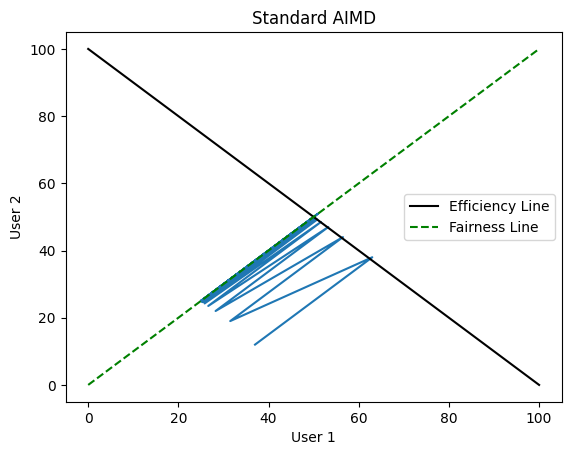

In [38]:
# Standard
ITERATESMAX = 5000 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Users
ALPHA = 1
BETA = 0.5

# TCP Reno Users
num_users = 2
reno_users = [TCPReno(np.random.randint(C+1)) for _ in range(num_users)]

name = "Standard AIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(reno_users):
    print(f"Initial Reno-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, reno_users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(reno_users):
    print(f"Final Reno-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)

******************** Aggressive  GAIMD ********************
Initial Reno-1 CWND: 10
Initial Reno-2 CWND: 100
Final Reno-1 CWND: 753.6615072288068
Final Reno-2 CWND: 753.6615072288068


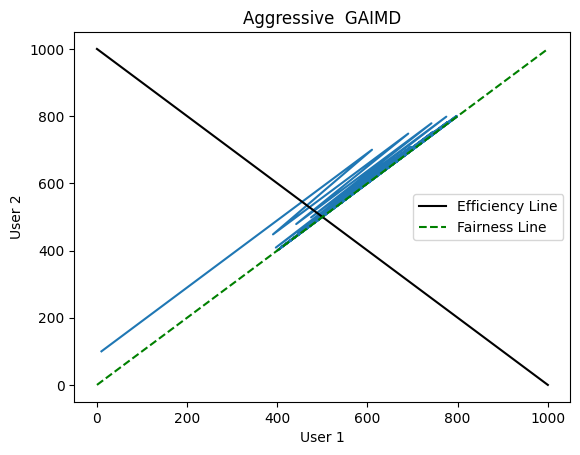

In [58]:
# Aggressive GAIMD
ITERATESMAX = 5000 # You can adjust this value as needed
# Max Capacity of the network
C = 1000

# Params
ALPHA = 1
BETA = 0.5

alphas = [0.3*C, 0.3*C]

betas = [0.8, 0.8]

init_cwnds = [10, 100]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Aggressive  GAIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(users):
    print(f"Initial Reno-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(users):
    print(f"Final Reno-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)

******************** Friendly  GAIMD ********************
Initial Reno-1 CWND: 10
Initial Reno-2 CWND: 20
Final Reno-1 CWND: 47.00000000000655
Final Reno-2 CWND: 47.00000000000655


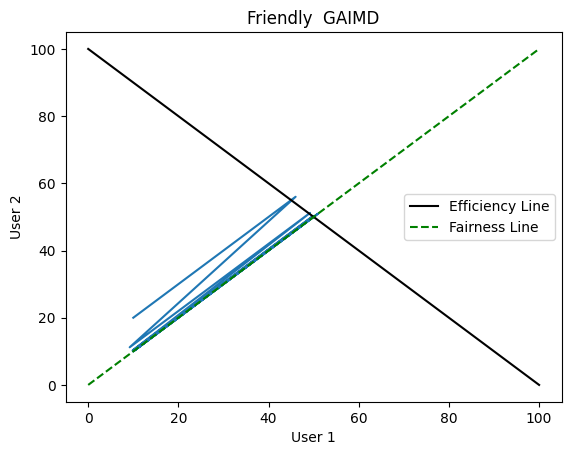

In [54]:
# Friendly GAIMD
ITERATESMAX = 5000 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.2, 0.2]

init_cwnds = [10, 20]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Friendly  GAIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(users):
    print(f"Initial Reno-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(users):
    print(f"Final Reno-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)

******************** Mixed  GAIMD ********************
Initial Reno-1 CWND: 10
Initial Reno-2 CWND: 20
Final Reno-1 CWND: 125.0
Final Reno-2 CWND: 999.9999999999998


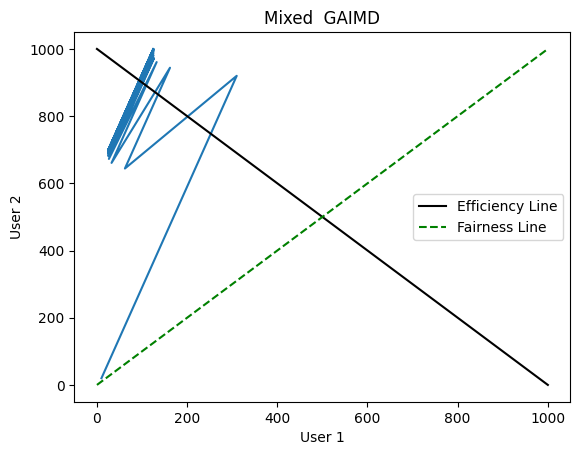

In [53]:
# Mixed GAIMD
# User 2 is more agreesive
ITERATESMAX = 5000 # You can adjust this value as needed
# Max Capacity of the network
C = 1000

# Params
ALPHA = 1
BETA = 0.5

alphas = [0.1*C, 0.3*C]

betas = [0.2, 0.7]

init_cwnds = [10, 20]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Mixed  GAIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(users):
    print(f"Initial Reno-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(users):
    print(f"Final Reno-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)

******************** Double AIMD ********************
Initial User-1 CWND: 8
Initial User-2 CWND: 9
Final User-1 CWND: 88.00027465820312
Final User-2 CWND: 59.999916076660156


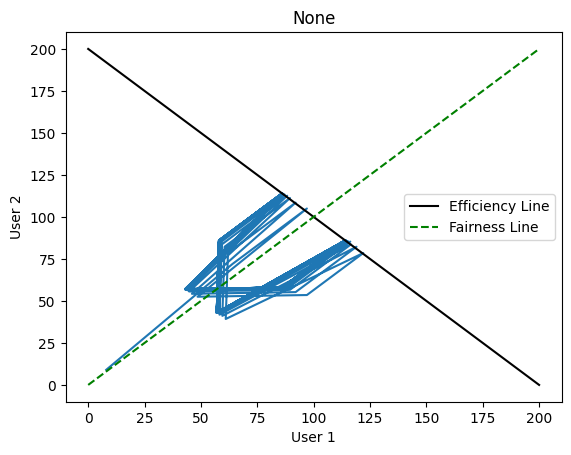

In [42]:
# Double
ITERATESMAX = 1000 # You can adjust this value as needed
# Max Capacity of the network
C = 200

# Users
ALPHA = 1
BETA = 0.5

# Users
num_users = 2
double_aimd_users = [DoubleAIMD(1, 0.5, np.random.randint(20), 50) for _ in range(num_users)]

name = "Double AIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(double_aimd_users):
    print(f"Initial User-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, double_aimd_users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(double_aimd_users):
    print(f"Final User-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise()

******************** Exponential AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 20
Final User-1 CWND: 54.038365771188246
Final User-2 CWND: 54.038365771188246


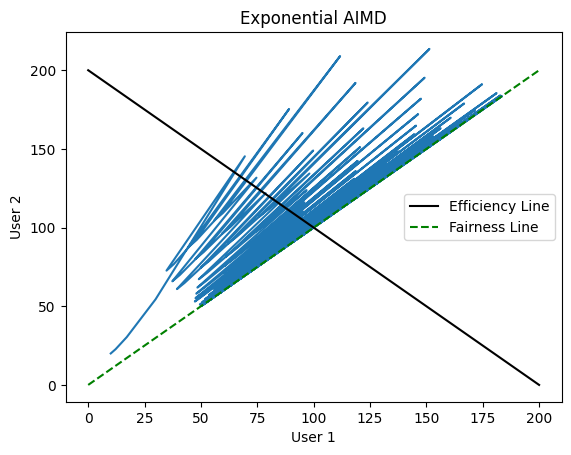

In [51]:
# Exponential
ITERATESMAX = 10000 # You can adjust this value as needed
# Max Capacity of the network
C = 200

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [10, 20]

ssthresholds = [float('inf'), float('inf')]

exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Exponential AIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(users):
    print(f"Initial User-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(users):
    print(f"Final User-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)

******************** Exponential AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 500
Final User-1 CWND: 285.47149705442047
Final User-2 CWND: 285.4714970544206


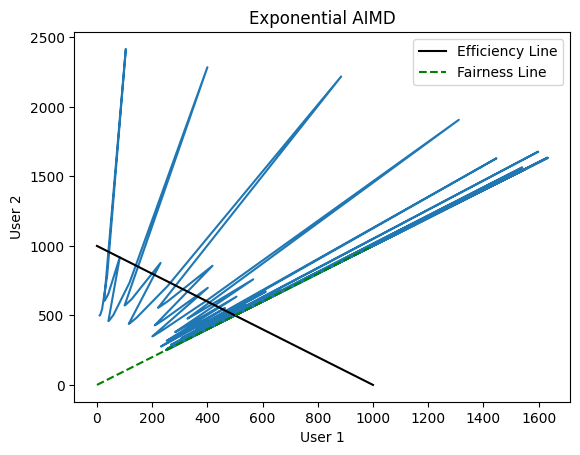

In [66]:
# Log
ITERATESMAX = 10000 # You can adjust this value as needed
# Max Capacity of the network
C = 1000

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [10, 500]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Exponential AIMD"
print("*"*20 +f" {name} " + "*"*20)

# Display the initial values
for i, u in enumerate(users):
    print(f"Initial User-{i+1} CWND:", u.RTT_tracker[0])

# Simulate the network
network = Network(C, users)
for i in range(1, ITERATESMAX):
    network.run_one_RTT()

# Display the final values
for i, u in enumerate(users):
    print(f"Final User-{i+1} CWND:", u.RTT_tracker[-1])

network.visualise(name)